In [80]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
from backtester.swarms import SwarmManager, SwarmRanker
from backtester.positionsizing import PositionSizingBase
import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
strategyname = 'strategy_270225'
d, info = matlab.loaddata('../mat/'+strategyname+'.mat')

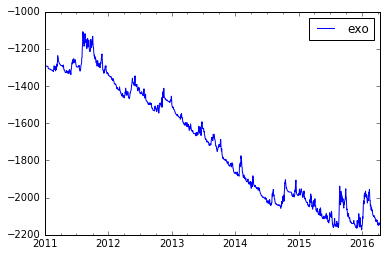

In [4]:
d.plot()


In [5]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

# Class based strategy

* Enter short when fast MA crosses down slow MA
* Exit when fast MA crosses up slow MA + median trailing stop


In [74]:
class StrategyMACrossTrail(StrategyBase):
    def __init__(self):
        # Initialize parent class
        super().__init__()
        
        # Define system's name
        self.name = 'MA Crossing with trailing stop'
        
        # This is a short strategy
        self.direction = -1
        
        # Define optimized params
        self.opts = [
            #OptParam(name, default_value, min_value, max_value, step)
            OptParam('SlowMAPeriod', 20, 10, 30, 2),
            OptParam('FastMAPeriod', 2, 2, 20, 1),
            OptParam('MedianPeriod', 5, 5, 20, 3)
        ]
        
        self.initialize()
        
    def initialize(self):
        #
        #  Loading EXO quotes from .mat file
        #
        strategyname = 'strategy_270225'
        self.data, info = matlab.loaddata('../mat/'+strategyname+'.mat')
        
        #
        # Estimating transaction costs in base points of price
        #
        
        # No costs
        #self.costs = pd.Series(0, self.data.index)
        
        # Flat costs / 1 point of EXO price per side / 2 roundtrip
        self.costs = pd.Series(1, self.data.index)
        
        # Dynamic costs (we could utilize dynamic costs models)
        #  Like slippage calculation on bid/ask data / etc
        # Some meta code (just in my imagination)
        # costmanager = CostManager('EXO.Ticker').LoadSlippageFromDB('2000-01-01', now)
        # self.costs = costmanager.getslippage() + pd.Series(0.1, self.data.index) # Slippage + commission
        
       
        
    def calculate(self, params=None):
        #        
        #
        #  Params is a tripple like (50, 10, 15), where:
        #   50 - slow MA period
        #   10 - fast MA period
        #   15 - median period
        #
        #  On every iteration of swarming algorithm, parameter set will be different.
        #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
        #       
        
        if params is None:
            # Return default parameters
            period_slow, period_fast, period_median = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            period_slow, period_fast, period_median = params
        
        # Defining EXO price
        px = self.data.exo
        
        #
        #
        # Indicator calculation
        #
        #
        slow_ma = px.rolling(period_slow) .mean()
        fast_ma = px.rolling(period_fast).mean()
        # Median based trailing stop
        trailing_stop = px.rolling(period_median).median().shift(1)        
    
        # Enry/exit rules
        entry_rule = CrossDown(fast_ma, slow_ma)
        exit_rule = (CrossUp(fast_ma, slow_ma) ) | (CrossUp(px, trailing_stop))
        
        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness 
        swarm_member_name = str((period_slow, period_fast, period_median))        
        
        return swarm_member_name, entry_rule, exit_rule
        

<h1>Backtest results</h2>

In [75]:
# Initiate the strategy
strategy = StrategyMACrossTrail()

In [76]:
# Running all parameters permutations in swarm
swarm = strategy.run_swarm()

In [77]:
# Saving swarm for future use
swarm.to_hdf('../swarms/macross_trailing.h5', 'swarm')

# Analyze the swarm

In [23]:
swarm = pd.read_hdf('../swarms/macross_trailing.h5', 'swarm')

### Exploriong swarm bounds

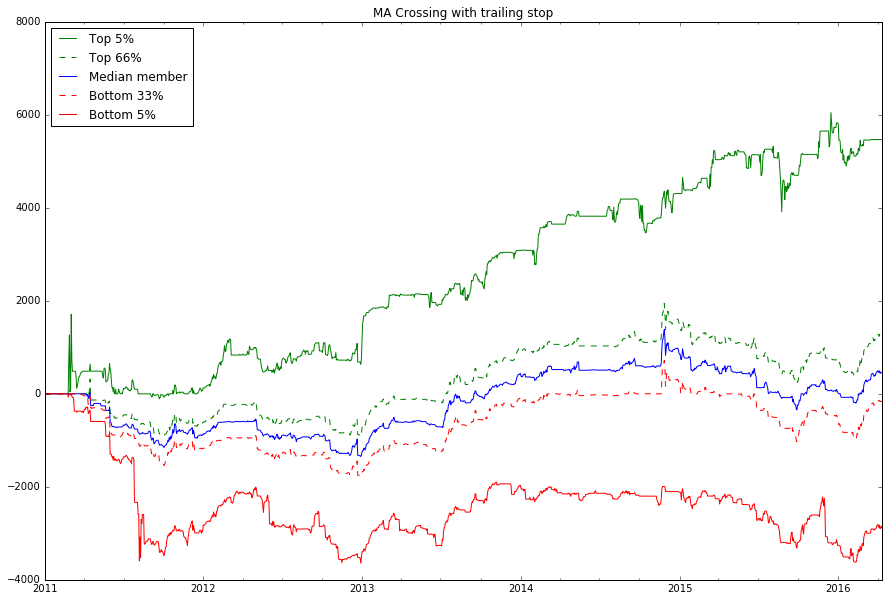

In [78]:
figsize(15,10)
title(strategy.name)
swarm.apply(lambda x: np.percentile(x, q=95), axis=1).plot(label='Top 5%', c='g')
swarm.apply(lambda x: np.percentile(x, q=66), axis=1).plot(label='Top 66%', c='g', style='k--')
swarm.apply(np.median, axis=1).plot(label='Median member')
swarm.apply(lambda x: np.percentile(x, q=33), axis=1).plot(label='Bottom 33%', c='r', style='k--')
swarm.apply(lambda x: np.percentile(x, q=5), axis=1).plot(label='Bottom 5%', c='r')

legend(loc=2);

## Picking the swarm members and compose a portfolio


In [89]:
# Swarm Manager context (settings)
context = {
    'nsystems': 5, # Number of swarm members to pick
}

# Rebalance the swarm every Monday
rebalance_time = swarm.index.dayofweek == 0


#
# Swarm ranking algorithm setup
#

# Rank systems by 14 days returns of equity
# FYI: ranking_func must me assigned without () at the end of line!
ranking_func =  SwarmRanker.highestreturns_14days


#
# Position sizing algorithm setup
#
initial_deposit = 100000
position_sizing = PositionSizingBase(initial_deposit) # Dummy class / i.e. no position sizing at all /


### Setting up SwarmManager

In [110]:
swarm_manager = SwarmManager(rebalancetime=rebalance_time, 
                             rankerfunc=ranking_func,
                             positionsizing=position_sizing,
                             context=context,
                            )

In [111]:
# Getting average swarm member equity
avg_swarm =SwarmManager.get_average_swarm(swarm)

In [114]:
data = {}
for slowp in np.arange(10, 20, 1):
        for fastp in np.arange(2, 10, 2):
            slow_ma = d.exo.rolling(slowp).mean()
            fast_ma = d.exo.rolling(fastp).mean()

            short_entry = CrossDown(fast_ma, slow_ma)
            short_exit = CrossUp(fast_ma, slow_ma)

            direction = -1
            pl1, inposition1 = backtester.backtest(d, short_entry, short_exit, direction )
            #trades = backtester.trades(pl1, inposition1)
            equity, stats = backtester.stats(pl1, inposition1)
            data[ str((slowp, fastp)) ] = equity

In [115]:
swarm2 = pd.DataFrame.from_dict(data)

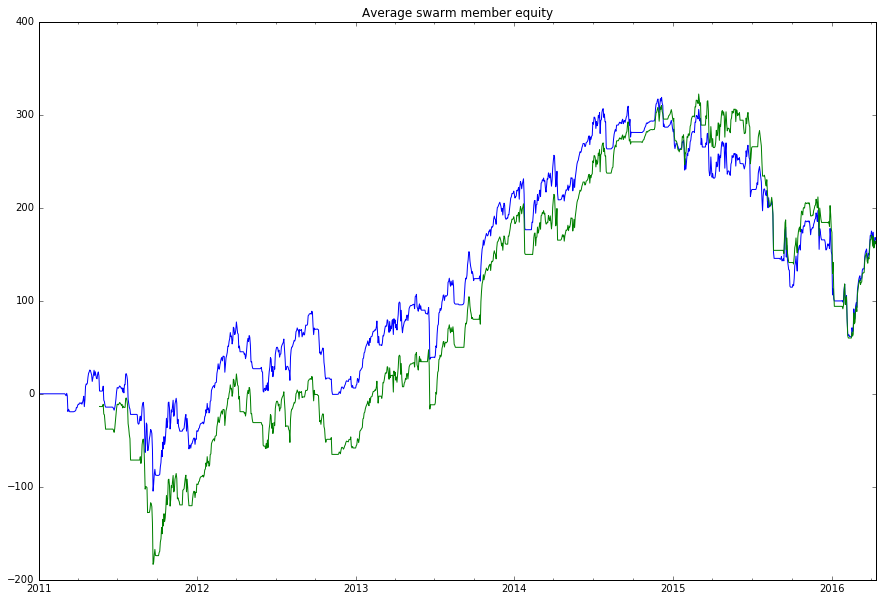

In [123]:
#eq_changes = swarm.diff()
eq_changes = swarm2.diff()

#is_picked_df = swarm_manager.backtest(swarm)
is_picked_df = swarm_manager.backtest(swarm2)
avg_picked_equity = eq_changes[is_picked_df].mean(axis=1).cumsum()
avg_all_equity = eq_changes.mean(axis=1).cumsum()


avg_all_equity.plot();
avg_picked_equity.plot()
title('Average swarm member equity');

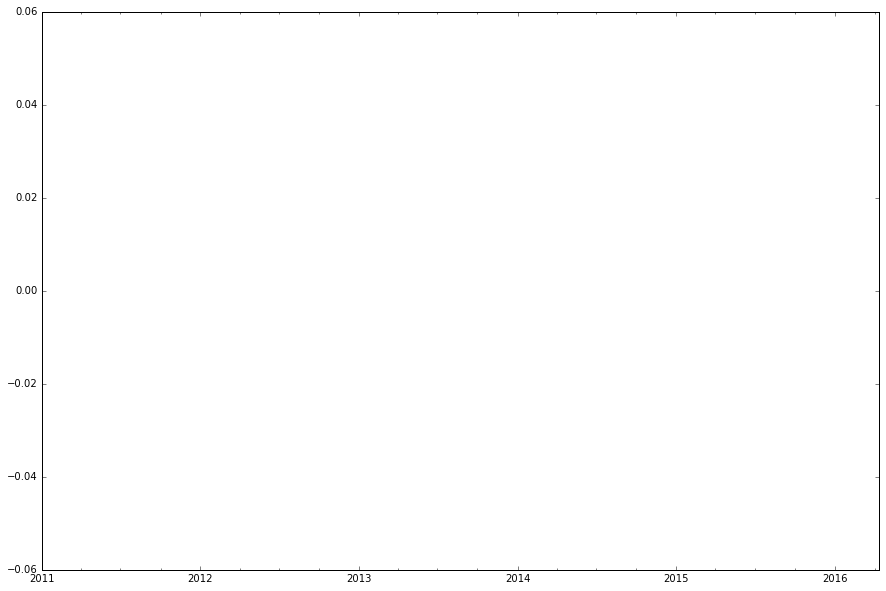

In [118]:
avg_picked_equity.plot()
#avg_all_equity.plot()

In [120]:
# TODO
# Взять концепцию Ван Тарпа
# Переложить ее на R - от волитильности актива
# Сделать NoteBook для презентации
# Сделать системы ММ через коэффициент (назовем его R), для ММ... будем повышать этот к-т в зависимости от прироста портфеля

ValueError: No objects to concatenate

In [121]:
swarm2

,"(10, 2)","(10, 4)","(10, 6)","(10, 8)","(11, 2)","(11, 4)","(11, 6)","(11, 8)","(12, 2)","(12, 4)",...,"(17, 6)","(17, 8)","(18, 2)","(18, 4)","(18, 6)","(18, 8)","(19, 2)","(19, 4)","(19, 6)","(19, 8)"
2011-01-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
